In [5]:
# IMPORTS
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from utils import function_utils
print(tf.config.list_physical_devices('XPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]


In [6]:
# LOAD DATASET

# X = np.loadtxt('X_comp_1_3.npy', delimiter=',')
X = function_utils.load_sympy_to_np_array('../../data/SE_comp_1_3.pkl')
y = np.loadtxt('../../data/y_comp_1_3.npy', delimiter=',')

# Preprocess the input
for i in range(X.shape[0]):
    if np.std(X[i]) == 0:
        X[i] = 0
        continue
    X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
# X = np.tanh(X)

n_samples = X.shape[0]
perm = np.random.permutation(n_samples)  # random permutation of indices

X_shuffled = X[perm]
y_shuffled = y[perm]

train_frac = 0.8
n_train = int(train_frac * n_samples)

X_train = X_shuffled[:n_train]
y_train = y_shuffled[:n_train]
X_val = X_shuffled[n_train:]
y_val = y_shuffled[n_train:]

/home/lethan3/miniconda3/envs/tensorflowintel/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/lethan3/miniconda3/envs/tensorflowintel/lib/python3.11/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [7]:
# import numpy as np
# import function_utils  # assuming load_sympy_to_np_array is here

# -----------------------
# LOAD DATA
# -----------------------
# X = function_utils.load_sympy_to_np_array('SE_comp_1_3.pkl')
# y = np.loadtxt('y_comp_1_3.npy', delimiter=',')

# -----------------------
# FILTER OUT NaNs / INFs
# -----------------------
valid_mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1)
X_valid = X[valid_mask]
y_valid = y[valid_mask]

print(f"Original size: {X.shape[0]}, Valid size: {X_valid.shape[0]}")

# -----------------------
# RANDOM SAMPLE (1/10 of total)
# -----------------------
n_total = X_valid.shape[0]
n_sample = max(1, n_total // 10)

perm = np.random.permutation(n_total)
selected_indices = perm[:n_sample]

X_sample = X_valid[selected_indices]
y_sample = y_valid[selected_indices]

print(f"Sampled {n_sample} rows (~1/10)")

# -----------------------
# TRAIN / VALIDATION SPLIT
# -----------------------
train_frac = 0.8
n_train = int(train_frac * n_sample)

perm_sample = np.random.permutation(n_sample)
X_sample = X_sample[perm_sample]
y_sample = y_sample[perm_sample]

X_train = X_sample[:n_train]
y_train = y_sample[:n_train]
X_val = X_sample[n_train:]
y_val = y_sample[n_train:]

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

# -----------------------
# SAVE TO FILES
# -----------------------
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

print("Arrays saved: X_train.npy, y_train.npy, X_val.npy, y_val.npy")


Original size: 50000, Valid size: 50000
Sampled 5000 rows (~1/10)
Train size: (4000, 5000), Val size: (1000, 5000)
Arrays saved: X_train.npy, y_train.npy, X_val.npy, y_val.npy


In [8]:
import numpy as np

# Assume X_train is your NumPy array of shape (n_samples, 5000)

# Check for NaNs
nan_mask = np.isnan(X_train)
has_nans = np.any(nan_mask)

# Check for Infs
inf_mask = np.isinf(X_train)
has_infs = np.any(inf_mask)

print(f"Contains NaNs? {has_nans}")
print(f"Contains Infs? {has_infs}")

if has_nans:
    nan_indices = np.argwhere(nan_mask)
    print("Indices of NaNs (first 10):", nan_indices[:10])

if has_infs:
    inf_indices = np.argwhere(inf_mask)
    print("Indices of Infs (first 10):", inf_indices[:10])


Contains NaNs? False
Contains Infs? False


In [9]:
import tensorflow as tf
import numpy as np

tfl = tf.keras.layers
SAMPLES = 5000

model = tf.keras.Sequential([
    tfl.Input(shape=(SAMPLES, 1)),

    tfl.SeparableConv1D(32, 7, padding="same", dilation_rate=1),
    tfl.LeakyReLU(alpha=0.1),
    tfl.Dropout(0.1),

    tfl.SeparableConv1D(32, 7, padding="same", dilation_rate=2),
    tfl.LeakyReLU(alpha=0.1),
    tfl.Dropout(0.1),

    tfl.SeparableConv1D(32, 7, padding="same", dilation_rate=4),
    tfl.LeakyReLU(alpha=0.1),
    tfl.Dropout(0.1),

    # Reduce max dilation to avoid exploding gradients
    tfl.SeparableConv1D(32, 7, padding="same", dilation_rate=8),
    tfl.LeakyReLU(alpha=0.1),
    tfl.Dropout(0.1),

    tfl.Conv1D(16, 1, padding="same"),
    tfl.LeakyReLU(alpha=0.1),

    tfl.GlobalAveragePooling1D(),
    tfl.Dense(1),
])

# Optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mse')


2025-12-08 18:14:38.290144: I tensorflow/core/common_runtime/next_pluggable_device/next_pluggable_device_factory.cc:118] Created 1 TensorFlow NextPluggableDevices. Physical device type: XPU


In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv1d (Separabl  (None, 5000, 32)          71        
 eConv1D)                                                        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5000, 32)          0         
                                                                 
 dropout (Dropout)           (None, 5000, 32)          0         
                                                                 
 separable_conv1d_1 (Separa  (None, 5000, 32)          1280      
 bleConv1D)                                                      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5000, 32)          0         
                                                                 
 dropout_1 (Dropout)         (None, 5000, 32)          0

In [11]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_rounded), tf.float32))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='mae',
              metrics=[rounded_accuracy])

Epoch 1/250


2025-12-08 18:14:39.966565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.


onednn_verbose,v1,info,oneDNN v3.8.0 (commit 5dc2e69f319ab59520c9096436488c11ab86fd93)
onednn_verbose,v1,info,cpu,runtime:DPC++,nthr:1
onednn_verbose,v1,info,cpu,isa:Intel AVX2 with Intel DL Boost, float16 and bfloat16 support
onednn_verbose,v1,info,gpu,runtime:DPC++
onednn_verbose,v1,info,cpu,engine,sycl cpu device count:1 
onednn_verbose,v1,info,cpu,engine,0,backend:OpenCL,name:Intel(R) Core(TM) Ultra 7 258V,driver_version:2025.20.10
onednn_verbose,v1,info,gpu,engine,sycl gpu device count:1 
onednn_verbose,v1,info,gpu,engine,0,backend:Level Zero,name:Intel(R) Arc(TM) Graphics,driver_version:1.6.34666,binary_kernels:enabled
onednn_verbose,v1,info,graph,backend,0:dnnl_backend
onednn_verbose,v1,info,experimental features are enabled
onednn_verbose,v1,info,use batch_normalization stats one pass is enabled
onednn_verbose,v1,info,GPU convolution v2 is disabled
onednn_verbose,v1,info,experimental functionality for sparse domain is enabled
onednn_verbose,v1,primitive,info,template:operation,

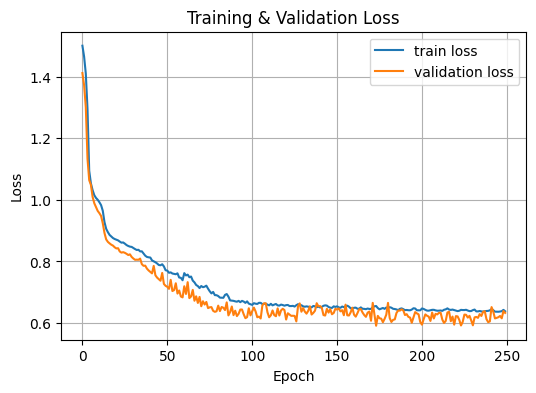

In [12]:
# Prepare inputs for Conv1D: add channel dim and cast to float32
X_train_in = np.asarray(X_train, dtype=np.float32)[..., np.newaxis]  # (batch, 5000, 1)
X_val_in   = np.asarray(X_val,   dtype=np.float32)[..., np.newaxis]  # (batch, 5000, 1)

# Targets to float32 (Keras accepts (batch,) or (batch,1); use (batch,1))
y_train_in = np.asarray(y_train, dtype=np.float32)
y_val_in   = np.asarray(y_val,   dtype=np.float32)
if y_train_in.ndim == 1:
    y_train_in = y_train_in[:, np.newaxis]
if y_val_in.ndim == 1:
    y_val_in = y_val_in[:, np.newaxis]

# Train
history = model.fit(
    X_train_in, y_train_in,
    epochs=250,
    batch_size=400,
    validation_data=(X_val_in, y_val_in),
)

# Plot training & validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
model.save("conv_model_12_8")

INFO:tensorflow:Assets written to: conv_model_12_8/assets


INFO:tensorflow:Assets written to: conv_model_12_8/assets


1.0


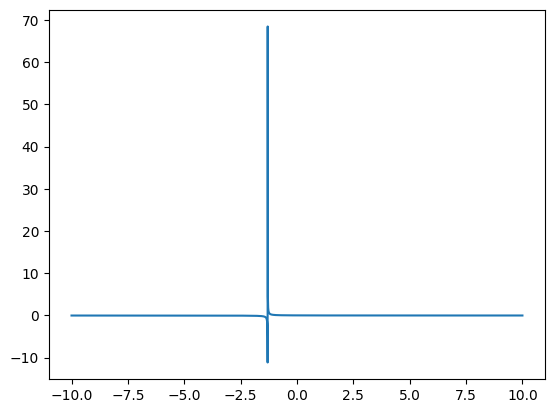

In [15]:
ind = 32
# print(np.min(X_val[ind]))
plt.plot(function_utils.XS, X_val[ind])
print(y_val[ind])

In [16]:
# Round predictions
y_pred = tf.round(model.predict(X_train, batch_size=32))

# Convert to numpy arrays
y_pred = y_pred.numpy().astype(int).flatten()
y_true = y_train.astype(int).flatten()

# Compute totals per class (0..3 assumed)
n_classes = 4
tot = np.bincount(y_true, minlength=n_classes)
correct = np.bincount(y_true[y_pred == y_true], minlength=n_classes)

# Class-wise accuracy
acc = correct / tot

acc

125/125 [==============================] - 2s 15ms/step


array([1.        , 0.14187192, 0.65942744, 0.111665  ])

In [17]:
np.sum(y_train == 0) / y_train.shape[0]
# model(X_train[:100])

0.24225

In [24]:
import plotly.graph_objects as go

def plot_confusion_matrix(y_true, y_pred, n_classes=4, normalize=False):
    # Compute confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    
    # Optional normalization (row-wise)
    if normalize:
        cm = cm.astype(float)
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sums, where=row_sums != 0)

    # Heatmap
    fig = go.Figure(
        data=go.Heatmap(
            z=cm,
            x=[f"{i}" for i in range(n_classes)],
            y=[f"{i}" for i in range(n_classes)],
            colorscale="Viridis",
            text=cm,
            texttemplate="%{text}",
            showscale=True,
        )
    )

    fig.update_layout(
        title="Complexity Estimation Confusion Matrix",
        xaxis_title="Predicted Complexity",
        yaxis_title="True Complexity",
        width=600,
        height=500,
    )
    
    fig.write_image(f"confusion.png", scale=3)

    return cm

plot_confusion_matrix(y_true, y_pred)


array([[969,   0,   0,   0],
       [ 17, 144, 854,   0],
       [103, 159, 668,  83],
       [ 96, 121, 673, 113]])

In [ ]:
# Assuming x_train and y_train are your training data
history = model.fit(X_train, y_train, epochs=250, batch_size=40000, validation_data=(X_val, y_val))

# Plot training & validation loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()